# LSTM

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.is_available()

True

In [4]:
device

device(type='cuda')

In [5]:
!nvidia-smi

Thu Oct 31 15:59:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   51C    P5              7W /   55W |    1231MiB /   8188MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Define DataSet

In [6]:

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, input_cols, seq_length=4):
        self.data = data
        self.target_col = target_col
        self.input_cols = input_cols
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.input_cols].iloc[idx:idx+self.seq_length].values
        y = self.data[self.target_col].iloc[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define the LSTM model

In [7]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays_indoor_person_counts.csv')

In [9]:
df.keys()

Index(['DateTime', 'electricity_15min_diff', 'heating_15min_diff',
       'is_holiday', 'day_of_week', 'hour_of_day', 'is_working_hour',
       'number_of_people', 'Temperature', 'Humidity', 'Dewpoint',
       'Sun Duration', 'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [10]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)


In [11]:
df

,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:15:00,1.38,5.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:30:00,1.20,5.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:45:00,1.37,5.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 01:00:00,1.15,5.0,True,5,1,False,0,11.5,85.0,9.1,0.0,0.0,4.2,220.0,11.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,True,5,23,False,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:15:00,1.64,2.0,True,5,23,False,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:30:00,1.87,3.0,True,5,23,False,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0


In [12]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

# Task1: Predict the heating_15min_diff using the weather data

## using weather data as features

In [13]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'
# seq_length = 4
seq_length = 96 # 24 hours

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [15]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')



Epoch [1/100], avg_epoch_mse_loss:: 5.0428
Epoch [2/100], avg_epoch_mse_loss:: 2.0634
Epoch [3/100], avg_epoch_mse_loss:: 1.8731
Epoch [4/100], avg_epoch_mse_loss:: 1.8187
Epoch [5/100], avg_epoch_mse_loss:: 1.7069
Epoch [6/100], avg_epoch_mse_loss:: 1.7388
Epoch [7/100], avg_epoch_mse_loss:: 1.6928
Epoch [8/100], avg_epoch_mse_loss:: 1.6646
Epoch [9/100], avg_epoch_mse_loss:: 1.6238
Epoch [10/100], avg_epoch_mse_loss:: 1.6081
Epoch [11/100], avg_epoch_mse_loss:: 1.5800
Epoch [12/100], avg_epoch_mse_loss:: 1.6058
Epoch [13/100], avg_epoch_mse_loss:: 1.5626
Epoch [14/100], avg_epoch_mse_loss:: 1.5860
Epoch [15/100], avg_epoch_mse_loss:: 1.5071
Epoch [16/100], avg_epoch_mse_loss:: 1.4953
Epoch [17/100], avg_epoch_mse_loss:: 1.4995
Epoch [18/100], avg_epoch_mse_loss:: 1.5558
Epoch [19/100], avg_epoch_mse_loss:: 1.5222
Epoch [20/100], avg_epoch_mse_loss:: 1.4842
Epoch [21/100], avg_epoch_mse_loss:: 1.4996
Epoch [22/100], avg_epoch_mse_loss:: 1.4809
Epoch [23/100], avg_epoch_mse_loss:: 1.47

In [16]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs).to(device)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test  mse Loss: 3.3322
Test RSME Loss: 1.8254
Test MAE: 1.4029
Test R² Score: 0.3168


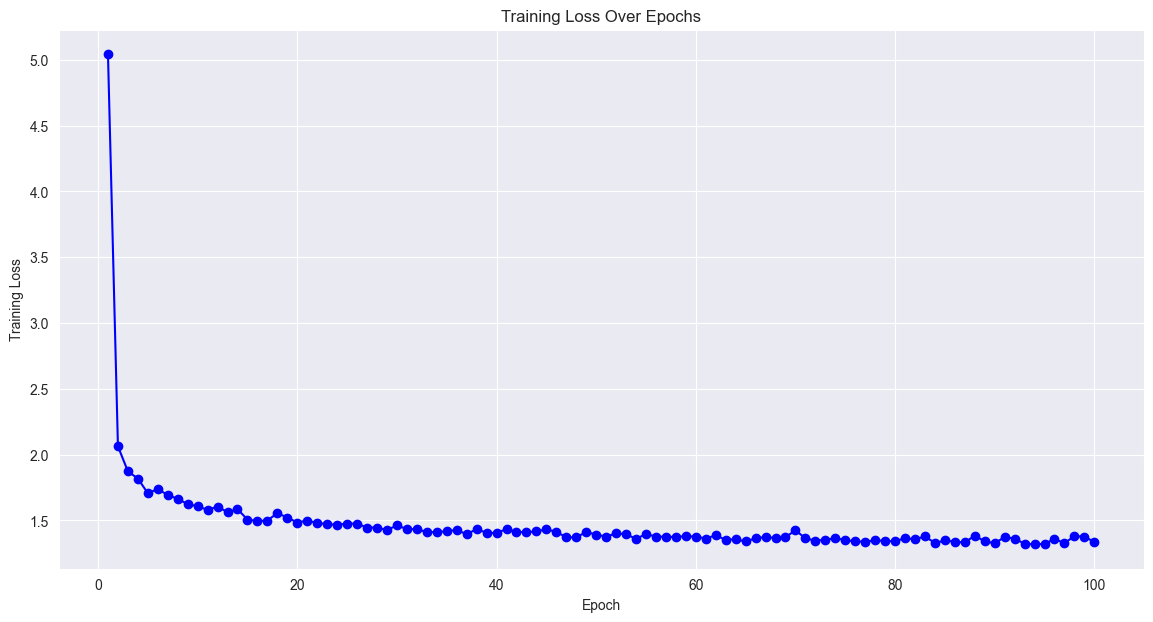

In [17]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

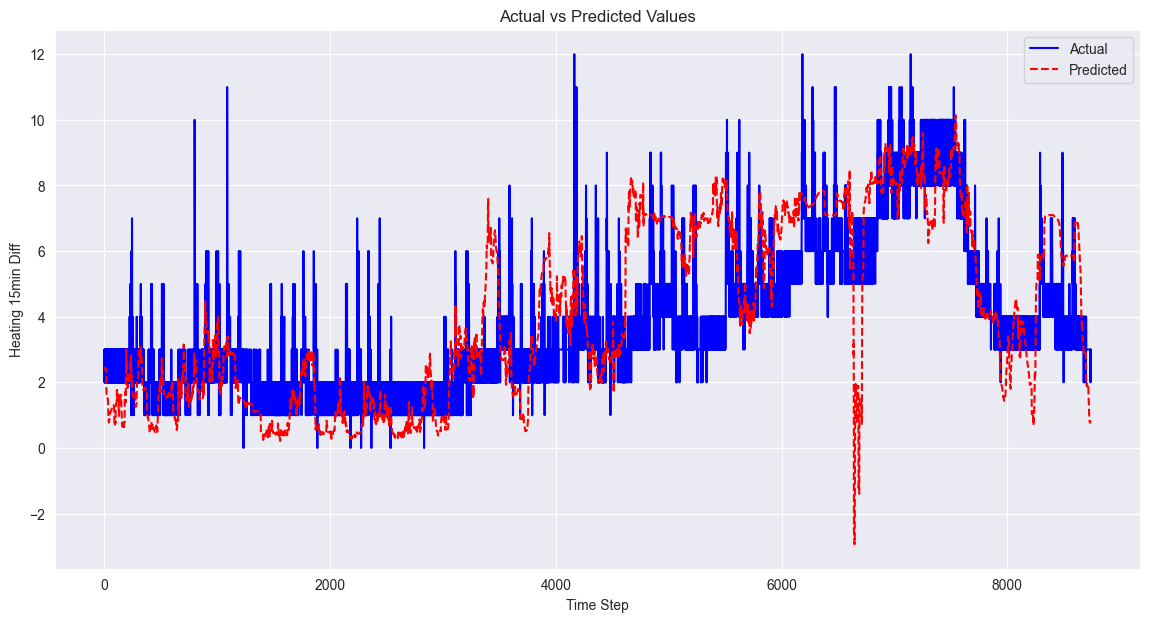

In [18]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Using data with holidays

In [19]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays.csv')

In [20]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [21]:
df

,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:15:00,1.38,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:30:00,1.20,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:45:00,1.37,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 01:00:00,1.15,5.0,1,5,1,0,0,11.5,85.0,9.1,0.0,0.0,4.2,220.0,11.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:15:00,1.64,2.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:30:00,1.87,3.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0


In [22]:
df.keys()

Index(['electricity_15min_diff', 'heating_15min_diff', 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35041 entries, 2022-01-01 00:00:00 to 2023-01-01 00:00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   electricity_15min_diff  35041 non-null  float64
 1   heating_15min_diff      35041 non-null  float64
 2   is_holiday              35041 non-null  int32  
 3   day_of_week             35041 non-null  int32  
 4   hour_of_day             35041 non-null  int32  
 5   is_working_hour         35041 non-null  int32  
 6   number_of_people        35041 non-null  int64  
 7   Temperature             35041 non-null  float64
 8   Humidity                35041 non-null  float64
 9   Dewpoint                35041 non-null  float64
 10  Sun Duration            35041 non-null  float64
 11  Precipitation Height    35041 non-null  float64
 12  Wind Speed              35041 non-null  float64
 13  Wind Direction          35041 non-null  float64
 14  ind

In [24]:
df.index.name

'DateTime'

In [25]:
# df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# df.set_index('DateTime', inplace=True)

In [26]:

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [27]:
# Drop rows with NaN values that may have been introduced by coercion
df.dropna(inplace=True)

In [28]:
# Define the date ranges for training and test data
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

In [29]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'# Prepare the data

# seq_length = 4
seq_length = 96 # 24 hours
train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [31]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')


Epoch [1/100], avg_epoch_mse_loss:: 4.4405
Epoch [2/100], avg_epoch_mse_loss:: 2.0276
Epoch [3/100], avg_epoch_mse_loss:: 1.9033
Epoch [4/100], avg_epoch_mse_loss:: 1.7678
Epoch [5/100], avg_epoch_mse_loss:: 1.7337
Epoch [6/100], avg_epoch_mse_loss:: 1.6845
Epoch [7/100], avg_epoch_mse_loss:: 1.6495
Epoch [8/100], avg_epoch_mse_loss:: 1.6446
Epoch [9/100], avg_epoch_mse_loss:: 1.6294
Epoch [10/100], avg_epoch_mse_loss:: 1.6263
Epoch [11/100], avg_epoch_mse_loss:: 1.5619
Epoch [12/100], avg_epoch_mse_loss:: 1.5325
Epoch [13/100], avg_epoch_mse_loss:: 1.5507
Epoch [14/100], avg_epoch_mse_loss:: 1.5271
Epoch [15/100], avg_epoch_mse_loss:: 1.5482
Epoch [16/100], avg_epoch_mse_loss:: 1.5396
Epoch [17/100], avg_epoch_mse_loss:: 1.5198
Epoch [18/100], avg_epoch_mse_loss:: 1.5218
Epoch [19/100], avg_epoch_mse_loss:: 1.5290
Epoch [20/100], avg_epoch_mse_loss:: 1.5214
Epoch [21/100], avg_epoch_mse_loss:: 1.4815
Epoch [22/100], avg_epoch_mse_loss:: 1.5010
Epoch [23/100], avg_epoch_mse_loss:: 1.46

In [32]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test mse Loss: 3.3293
Test RSME Loss: 1.8246
Test MAE: 1.4054
Test R² Score: 0.3184


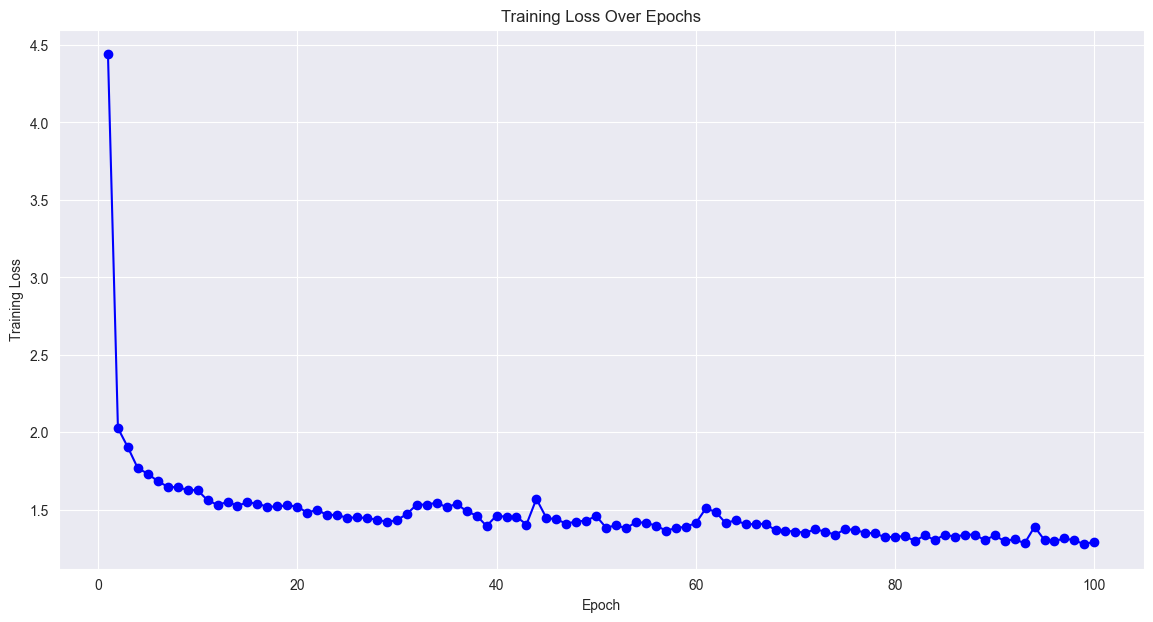

In [33]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

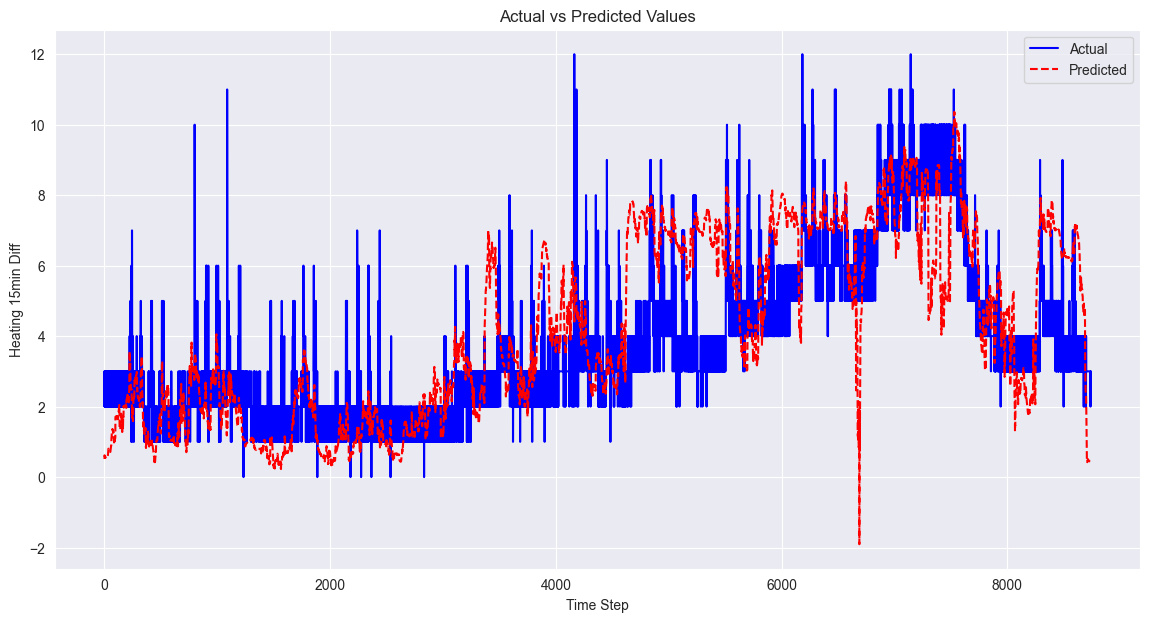

In [34]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [35]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'heating_15min_diff'# Prepare the data

# seq_length = 4
seq_length = 96 # 24 hours
train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [37]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')


Epoch [1/100], avg_epoch_mse_loss:: 5.5728
Epoch [2/100], avg_epoch_mse_loss:: 2.0812
Epoch [3/100], avg_epoch_mse_loss:: 1.8458
Epoch [4/100], avg_epoch_mse_loss:: 1.7299
Epoch [5/100], avg_epoch_mse_loss:: 1.6625
Epoch [6/100], avg_epoch_mse_loss:: 1.6147
Epoch [7/100], avg_epoch_mse_loss:: 1.5773
Epoch [8/100], avg_epoch_mse_loss:: 1.5671
Epoch [9/100], avg_epoch_mse_loss:: 1.5355
Epoch [10/100], avg_epoch_mse_loss:: 1.5316
Epoch [11/100], avg_epoch_mse_loss:: 1.5110
Epoch [12/100], avg_epoch_mse_loss:: 1.5118
Epoch [13/100], avg_epoch_mse_loss:: 1.4868
Epoch [14/100], avg_epoch_mse_loss:: 1.5012
Epoch [15/100], avg_epoch_mse_loss:: 1.4896
Epoch [16/100], avg_epoch_mse_loss:: 1.4842
Epoch [17/100], avg_epoch_mse_loss:: 1.4675
Epoch [18/100], avg_epoch_mse_loss:: 1.4596
Epoch [19/100], avg_epoch_mse_loss:: 1.4740
Epoch [20/100], avg_epoch_mse_loss:: 1.5380
Epoch [21/100], avg_epoch_mse_loss:: 1.4630
Epoch [22/100], avg_epoch_mse_loss:: 1.4413
Epoch [23/100], avg_epoch_mse_loss:: 1.45

In [38]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 3.2258
Test RSME Loss: 1.7960
Test MAE: 1.4129
Test R² Score: 0.3401


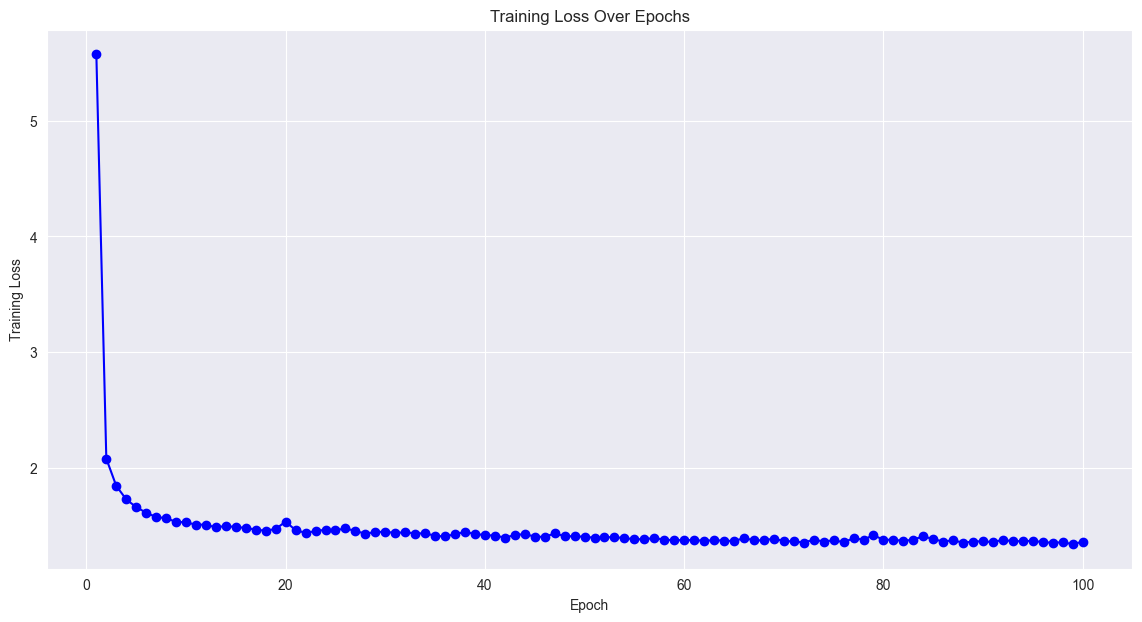

In [39]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

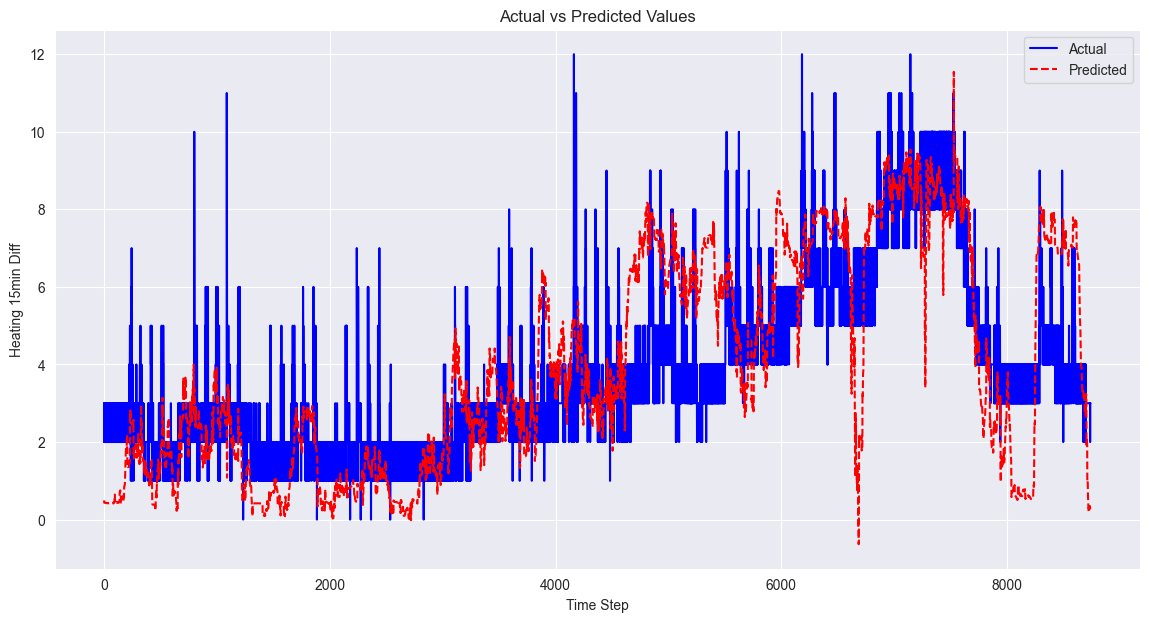

In [40]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Task2: electricity_15min_diff

## using weather data as features

In [95]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [96]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [97]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.2680
Epoch [2/100], avg_epoch_mse_loss:: 11.0155
Epoch [3/100], avg_epoch_mse_loss:: 10.9985
Epoch [4/100], avg_epoch_mse_loss:: 11.0024
Epoch [5/100], avg_epoch_mse_loss:: 10.9990
Epoch [6/100], avg_epoch_mse_loss:: 10.9837
Epoch [7/100], avg_epoch_mse_loss:: 10.9840
Epoch [8/100], avg_epoch_mse_loss:: 10.9810
Epoch [9/100], avg_epoch_mse_loss:: 10.9878
Epoch [10/100], avg_epoch_mse_loss:: 10.9761
Epoch [11/100], avg_epoch_mse_loss:: 10.9689
Epoch [12/100], avg_epoch_mse_loss:: 10.9572
Epoch [13/100], avg_epoch_mse_loss:: 10.9596
Epoch [14/100], avg_epoch_mse_loss:: 10.9536
Epoch [15/100], avg_epoch_mse_loss:: 10.9632
Epoch [16/100], avg_epoch_mse_loss:: 10.9496
Epoch [17/100], avg_epoch_mse_loss:: 10.9593
Epoch [18/100], avg_epoch_mse_loss:: 10.9554
Epoch [19/100], avg_epoch_mse_loss:: 10.9356
Epoch [20/100], avg_epoch_mse_loss:: 10.9440
Epoch [21/100], avg_epoch_mse_loss:: 10.9381
Epoch [22/100], avg_epoch_mse_loss:: 10.9437
Epoch [23/100], avg

In [98]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 1.2072
Test RSME Loss: 1.0987
Test MAE: 0.7847
Test R² Score: -0.2154


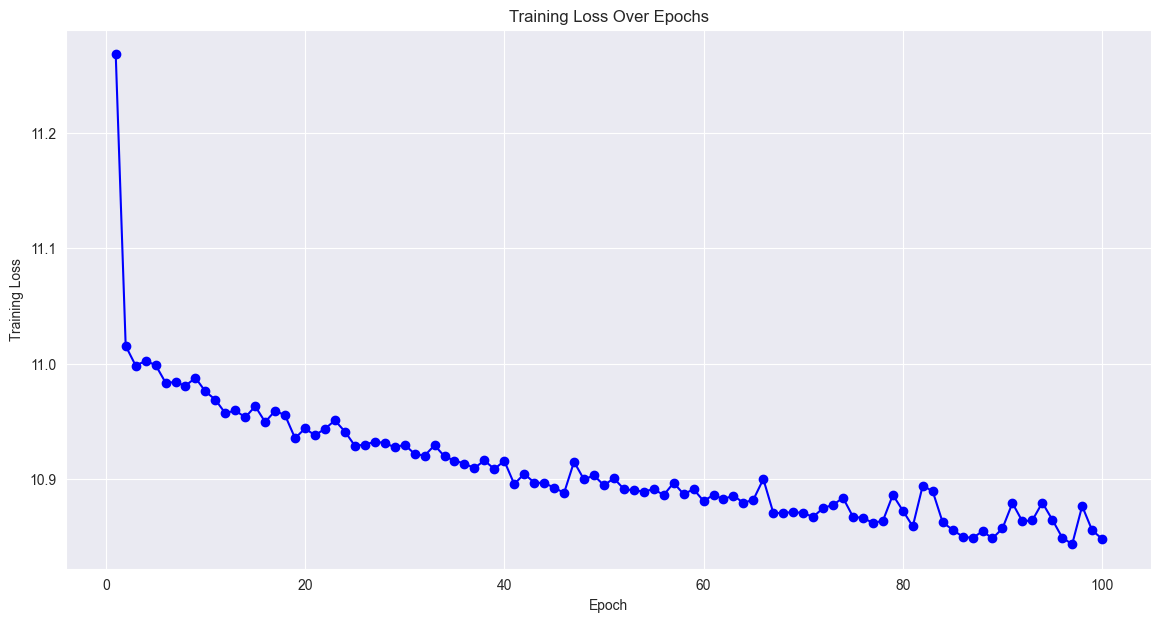

In [99]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

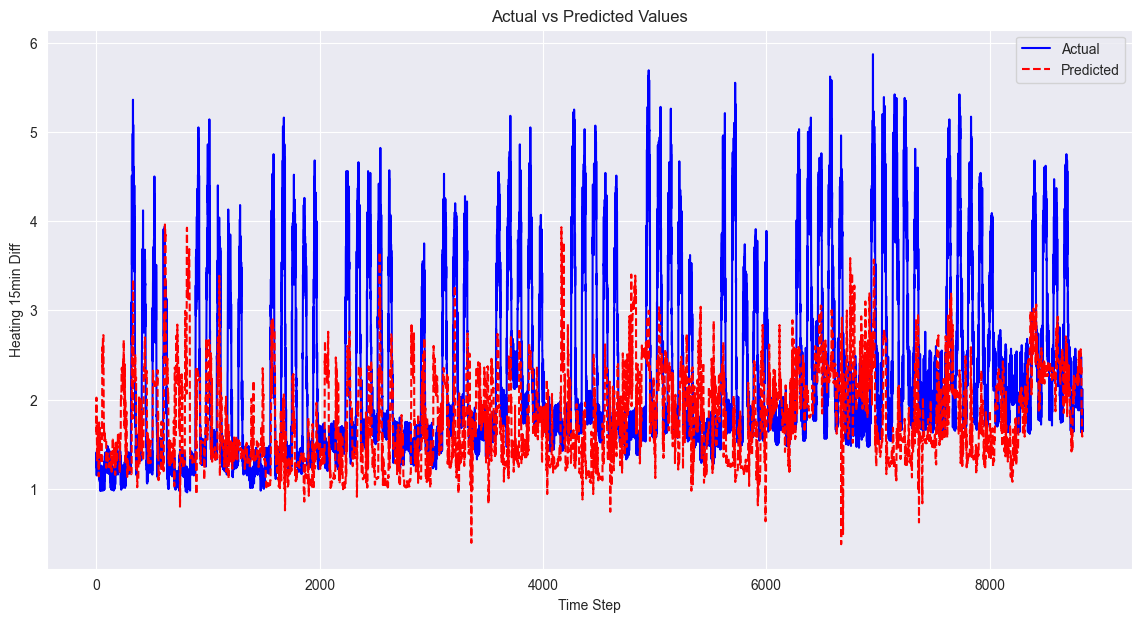

In [100]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using data with holidays

In [101]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [102]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [103]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.1694
Epoch [2/100], avg_epoch_mse_loss:: 10.6156
Epoch [3/100], avg_epoch_mse_loss:: 10.6043
Epoch [4/100], avg_epoch_mse_loss:: 10.5723
Epoch [5/100], avg_epoch_mse_loss:: 10.5484
Epoch [6/100], avg_epoch_mse_loss:: 10.5198
Epoch [7/100], avg_epoch_mse_loss:: 10.5071
Epoch [8/100], avg_epoch_mse_loss:: 10.5093
Epoch [9/100], avg_epoch_mse_loss:: 10.5169
Epoch [10/100], avg_epoch_mse_loss:: 10.4975
Epoch [11/100], avg_epoch_mse_loss:: 10.4923
Epoch [12/100], avg_epoch_mse_loss:: 10.4735
Epoch [13/100], avg_epoch_mse_loss:: 10.4727
Epoch [14/100], avg_epoch_mse_loss:: 10.4837
Epoch [15/100], avg_epoch_mse_loss:: 10.4581
Epoch [16/100], avg_epoch_mse_loss:: 10.4531
Epoch [17/100], avg_epoch_mse_loss:: 10.4878
Epoch [18/100], avg_epoch_mse_loss:: 10.4578
Epoch [19/100], avg_epoch_mse_loss:: 10.4714
Epoch [20/100], avg_epoch_mse_loss:: 10.4507
Epoch [21/100], avg_epoch_mse_loss:: 10.4479
Epoch [22/100], avg_epoch_mse_loss:: 10.4474
Epoch [23/100], avg

In [104]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 0.3847
Test RSME Loss: 0.6202
Test MAE: 0.4716
Test R² Score: 0.6132


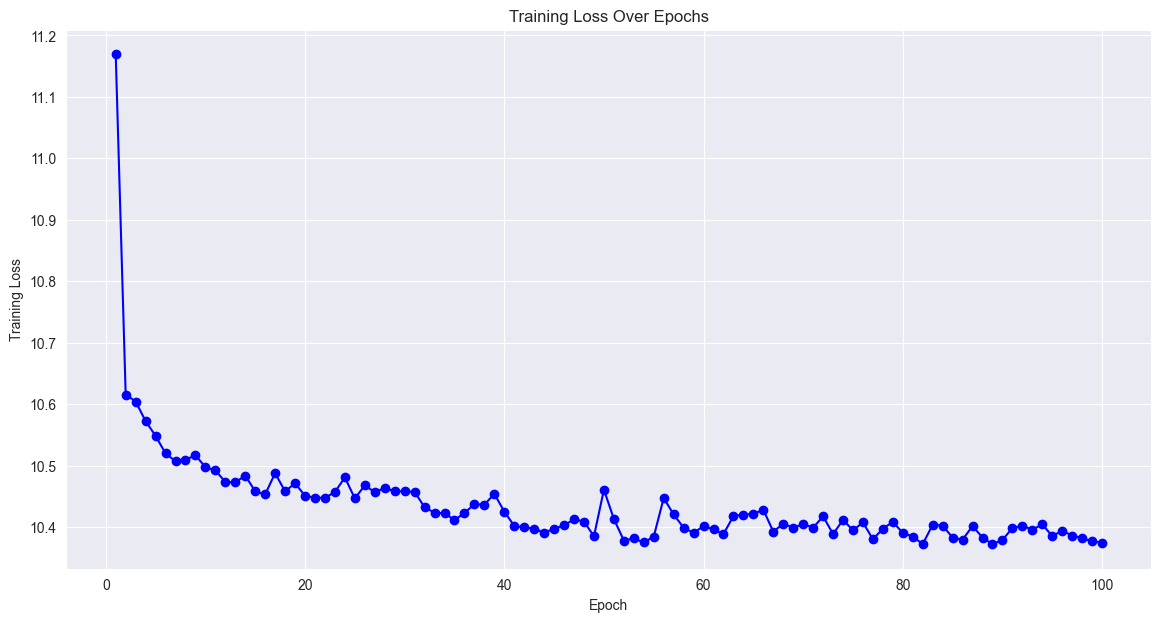

In [105]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

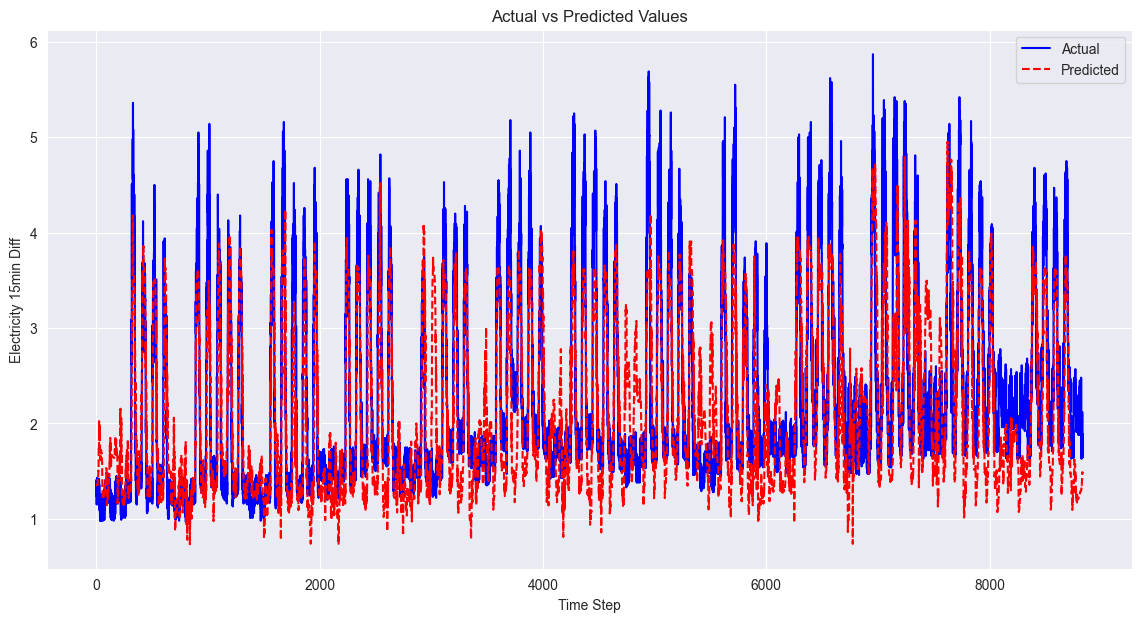

In [106]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [107]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'electricity_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [108]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [109]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.0855
Epoch [2/100], avg_epoch_mse_loss:: 10.6782
Epoch [3/100], avg_epoch_mse_loss:: 10.6370
Epoch [4/100], avg_epoch_mse_loss:: 10.6211
Epoch [5/100], avg_epoch_mse_loss:: 10.5830
Epoch [6/100], avg_epoch_mse_loss:: 10.5577
Epoch [7/100], avg_epoch_mse_loss:: 10.5485
Epoch [8/100], avg_epoch_mse_loss:: 10.5168
Epoch [9/100], avg_epoch_mse_loss:: 10.5031
Epoch [10/100], avg_epoch_mse_loss:: 10.5047
Epoch [11/100], avg_epoch_mse_loss:: 10.4972
Epoch [12/100], avg_epoch_mse_loss:: 10.5134
Epoch [13/100], avg_epoch_mse_loss:: 10.4985
Epoch [14/100], avg_epoch_mse_loss:: 10.5040
Epoch [15/100], avg_epoch_mse_loss:: 10.4855
Epoch [16/100], avg_epoch_mse_loss:: 10.4714
Epoch [17/100], avg_epoch_mse_loss:: 10.4793
Epoch [18/100], avg_epoch_mse_loss:: 10.4816
Epoch [19/100], avg_epoch_mse_loss:: 10.4685
Epoch [20/100], avg_epoch_mse_loss:: 10.4766
Epoch [21/100], avg_epoch_mse_loss:: 10.4547
Epoch [22/100], avg_epoch_mse_loss:: 10.4623
Epoch [23/100], avg

In [110]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 0.3817
Test RSME Loss: 0.6178
Test MAE: 0.4645
Test R² Score: 0.6169


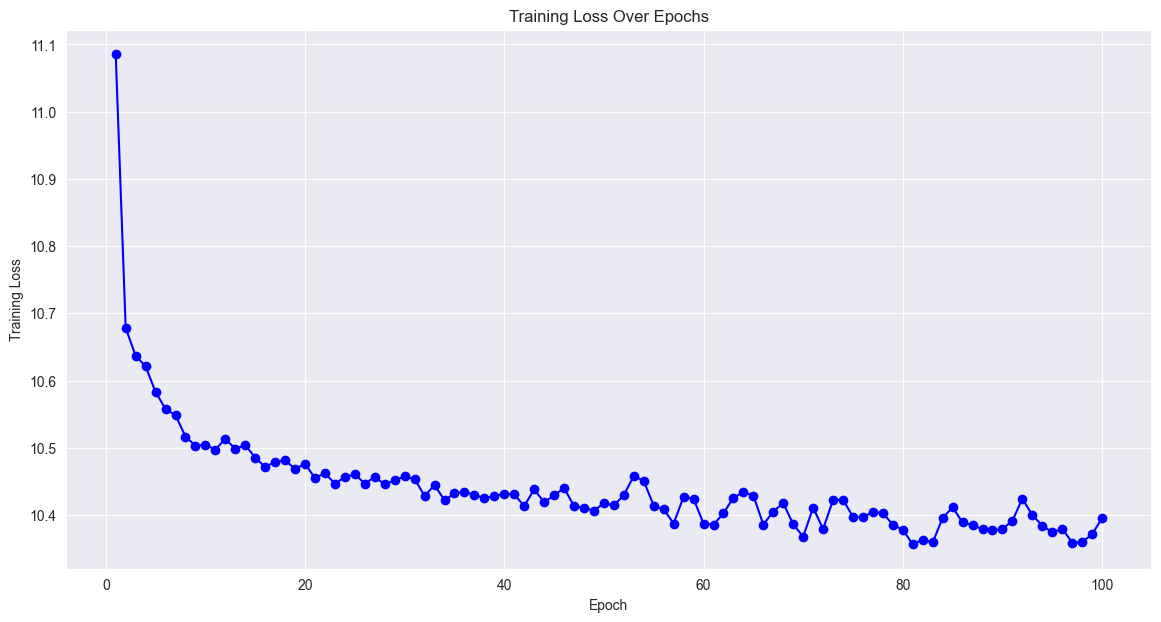

In [111]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

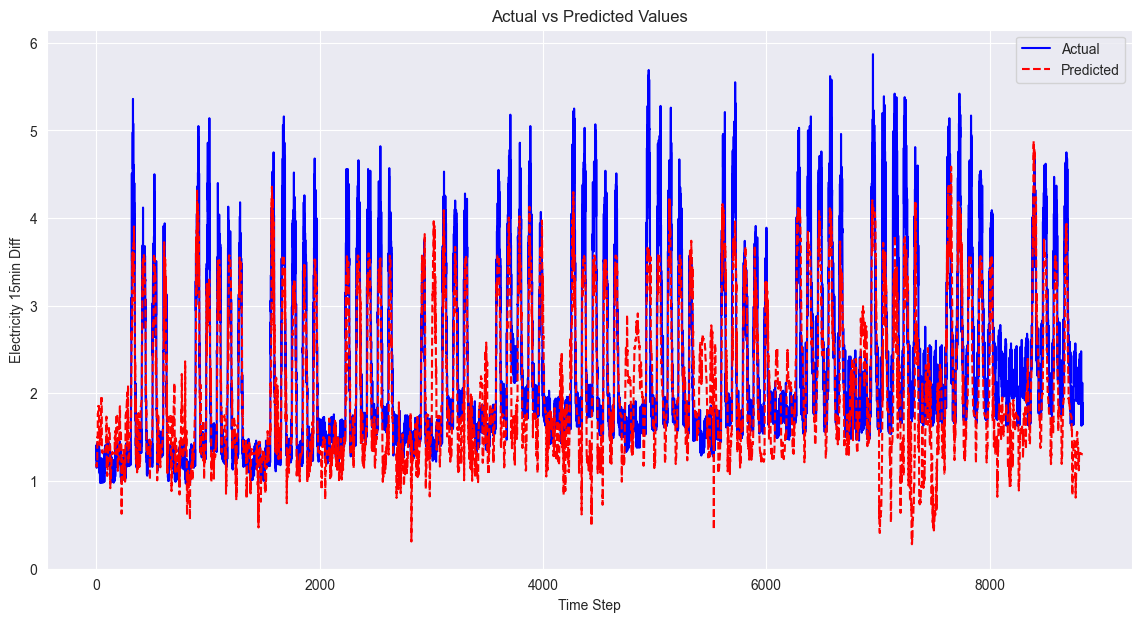

In [112]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()